### Load data

In [240]:
import pandas as pd 

# load and set index
df = pd.read_csv('../data/fbref/player_stats.csv')
df = df.set_index(df['Player'], drop=True)
df = df.fillna(0)

# seperate standard info and features
#l = ['unique_id','Season','League','Team','Player',	'Nation',	'Pos',	'Age', 'Global Pos',
#     "Playing Time_Starts",	"Playing Time_Min",	"Playing Time_90s"]

player_info_cols = ['unique_id','Season', 'League', 'Team', 'Player', 'Nation', 'Pos','Global Pos', 'Age','Matches Played','Playing Time_Starts','Playing Time_Min','Playing Time_90s']


player_info = df[player_info_cols]

features = [col for col in df.columns if col not in player_info_cols]
df = df[features]

# Set seed for reproducibility
SEED = 42

In [241]:
df.head()

,Tackles_Att,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Interceptions,Clearances,Errors,Dribblers_Tkl_Succ,Dribblers_Tkl_Att,Dribblers_Tkl_Lost,...,Playing Time_Mn/MP,Starts,Mn/Start,Compl,Subs,unSub,PPM,onG,onGA,On-Off
Player,,,,,,,,,,,,,,,,,,,,,
Ederson,3.0,3.0,0.0,0.0,1.0,10.0,2.0,1.0,2.0,1.0,...,90.0,35.0,90.0,35.0,0.0,3.0,2.34,89.0,32.0,0.30
Rodri,67.0,28.0,28.0,11.0,33.0,43.0,1.0,26.0,52.0,26.0,...,81.0,34.0,85.0,23.0,2.0,1.0,2.39,83.0,26.0,1.06
Erling Haaland,3.0,0.0,2.0,1.0,3.0,14.0,0.0,1.0,5.0,4.0,...,79.0,33.0,83.0,21.0,2.0,1.0,2.37,84.0,26.0,1.47
Kevin De Bruyne,28.0,3.0,12.0,13.0,9.0,10.0,0.0,14.0,39.0,25.0,...,76.0,28.0,84.0,16.0,4.0,3.0,2.31,69.0,23.0,0.37
İlkay Gündoğan,30.0,7.0,13.0,10.0,20.0,13.0,0.0,12.0,33.0,21.0,...,76.0,27.0,85.0,17.0,4.0,7.0,2.39,71.0,20.0,1.11


### Load feature space

In [242]:
player_info_cols = ['Season', 'League', 'Team', 'Player', 'Nation', 'Pos','Global Pos', 'Age','Matches Played','Playing Time_Starts','Playing Time_Min','Playing Time_90s']

def_cols = ['Tackles_Att', 'Tackles_Def 3rd', 'Tackles_Mid 3rd',
        'Tackles_Att 3rd','Interceptions', 'Clearances','Errors',
        'Dribblers_Tkl_Succ','Dribblers_Tkl_Att','Dribblers_Tkl_Lost',
        'Blocks_Total', 'Blocks_Shots',
        ]

possession_cols = ['Touches_Number', 'Touches_Def Pen', 'Touches_Def 3rd',
       'Touches_Mid 3rd', 'Touches_Att 3rd', 'Touches_Att Pen','Take-Ons_Att', 'Take-Ons_Succ',
       'Take-Ons_Tkld','Take-Ons_Tkld%','Carries_Number', 'Carries_TotDist',
       'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3', 'Carries_CPA',
       'Carries_Mis', 'Carries_Dis','Receiving_Succ', 'Receiving_PrgR'
        ]
passing_cols = ['Total_Cmp', 'Total_Att', 'Total_Cmp%', 'Total_TotDist',
       'Total_PrgDist','Short_Cmp', 'Short_Att', 'Short_Cmp%', 'Medium_Cmp',
       'Medium_Att', 'Medium_Cmp%', 'Long_Cmp', 'Long_Att', 'Long_Cmp%','Assists', 'Key Passes', 'Passes_to_1/3',
       'Passes_to_Penalt_Area', 'Crosses_into_Penalty_Area','Progressive Passes']

gsc_cols = ['SCA', 'SCA90', 'SCA Types_PassLive', 'SCA Types_PassDead',
       'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld', 'SCA Types_Def', 'GCA',
       'GCA90', 'GCA Types_PassLive', 'GCA Types_PassDead', 'GCA Types_TO',
       'GCA Types_Sh', 'GCA Types_Fld', 'GCA Types_Def'
        ]

shooting_cols = ['Goals', 'Shots', 'SoT', 'SoT%', 'Shots/90','Goals/Shot', 'Goals/SoT']

adv_goalkeeping = ['Goals_GA', 'Goals_PKA', 'Goals_FK', 'Goals_CK', 'Goals_OG', 'PSxG',
       'PSxG/SoT', 'PSxG+/-', '/90', 'Launched_Cmp', 'Launched_Att',
       'Launched_Cmp%', 'Passes_Att', 'Passes_Thr', 'Passes_Launch%',
       'Passes_AvgLen', 'Goal Kicks_Att', 'Goal Kicks_Launch%',
       'Goal Kicks_AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90',
       'AvgDist']
goalkeeping_cols = ['GA',
       'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L', 'CS', 'CS%',
       'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKsv',
       'Penalty Kicks_PKm', 'Penalty Kicks_Save%']


misc_cols = ['2CrdY', 'Fls', 'Fld', 'Off', 'Crs','PKwon', 
            'PKcon', 'OG', 'Recov', 'Aerial Duels_Won',
            'Aerial Duels_Lost'
        ]



playing_time_cols = ['Playing Time_Minutes', 'Playing Time_Mn/MP','Starts', 'Mn/Start', 'Compl',
                     'Subs', 'unSub', 'PPM','onG', 'onGA','On-Off'
                    ]

feature_vector = (player_info_cols + def_cols + possession_cols + passing_cols + 
               gsc_cols + shooting_cols + adv_goalkeeping + goalkeeping_cols + 
               misc_cols + playing_time_cols)

### Helper functions

In [303]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cosine_similarity(embeddings):
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    query_embedding = embeddings_norm[1]
    cosine_similarities = np.dot(embeddings_norm, query_embedding)
    return cosine_similarities



def scatterplot_with_labels(df, x_col, y_col, num_labels=10, top_size=200, rest_size=100, fontsize=9, dist_measure='',title=None):
    """
    Creates a scatter plot with custom coloring, labels, and different sizes for top and rest observations.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - x_col: string, name of the column for the x-axis.
    - y_col: string, name of the column for the y-axis.
    - num_labels: int, number of points to label (default: 10).
    - top_size: int, size of the scatter points for the first `num_labels` observations.
    - rest_size: int, size of the scatter points for the remaining observations.
    """
    # Define the color map: first one purple, next num_labels orange, and the rest blue
    colors = ['purple'] + ['orange'] * num_labels + ['grey'] * (len(df) - (num_labels + 1))
    
    # Define sizes for top and rest
    sizes = [top_size] * (num_labels + 1) + [rest_size] * (len(df) - (num_labels + 1))

    # Create the scatter plot
    plt.scatter(df[x_col], df[y_col], c=colors, s=sizes)
    
    # Label the first num_labels observations
    for i in range(num_labels):
        plt.text(df[x_col][i], df[y_col][i]+ 3, df.index[i], fontsize=fontsize)
    
    # Set labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    if title is None:
        plt.title(f'{x_col} vs {y_col} - {dist_measure}')
    else:
        plt.title(title)

    # Show plot
    plt.show()

def get_feature_indices(selected_features):
    start_idx = df.columns.get_loc(selected_features[0])
    end_idx = df.columns.get_loc(selected_features[-1])
    return start_idx, end_idx

### Scale

In [244]:
from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [245]:
df_scaled.shape

(4803, 137)

### PCA (optional)

In [246]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)  # Retain 95% of variance
df_pca = pca.fit_transform(df_scaled)

### Autoencoder
#### Dataloader

In [247]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(SEED)
np.random.seed(SEED)

# Convert to PyTorch tensors
data_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(data_tensor, data_tensor)  # Input and target are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model parameters
input_dim = df_scaled.shape[1]  # Input dimensions = number of features
encoding_dim = 50  # Size of the bottleneck layer

#### Model

In [248]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim)  # Bottleneck layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Output layer (reconstruction)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Criterion and Optimizer

In [249]:
# model
model = Autoencoder(input_dim, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### Training

In [250]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    """
    Train a given model with specified parameters.

    Args:
        model: The model to train.
        dataloader: The data loader providing the input data.
        criterion: The loss function (e.g., reconstruction loss).
        optimizer: The optimizer (e.g., Adam, SGD).
        num_epochs: Number of epochs to train the model (default: 50).
        log_interval: Interval for printing the loss during training (default: 10 epochs).

    Returns:
        Trained model.
    """
    for epoch in range(num_epochs):
        for data in dataloader:
            inputs, _ = data  # Inputs are the data
            optimizer.zero_grad()

            # Forward pass: encode-decode
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Reconstruction loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Logging every log_interval epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

model = train_model(model,dataloader,criterion,optimizer,50)

Epoch [10/50], Loss: 1.9141
Epoch [20/50], Loss: 1.7930
Epoch [30/50], Loss: 0.4700
Epoch [40/50], Loss: 0.3416
Epoch [50/50], Loss: 0.2704


#### Bottleneck Layer

In [251]:
# Extract reduced embeddings
with torch.no_grad():  # No need to track gradients for inference
    embeddings = model.encoder(data_tensor).numpy()

print(embeddings.shape)


(4803, 50)


#### Compute cosine

In [276]:
# Normalize the embeddings (L2 normalization)
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Let's say the first row is the query point
query_embedding = embeddings_norm[795]

# Compute cosine similarities between the query and the rest
cosine_similarities = np.dot(embeddings_norm, query_embedding)

# Get the top 10 most similar samples
top_k_similar_indeces = np.argsort(cosine_similarities)
top_k_df = player_info.iloc[top_k_similar_indeces].copy()
top_k_df['cosine_similarity'] = cosine_similarities[top_k_similar_indeces]

top_k_df = top_k_df.sort_values('cosine_similarity',ascending=False).drop(columns='unique_id')

top_k_df.head(20) # apply filters

,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,cosine_similarity
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,1.000000
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,0.983434
Burak Yılmaz,2022-2023,EreDivisie,Fortuna Sittard,Burak Yılmaz,TUR,FW,FW,37.0,26.0,24.0,2218.0,24.6,0.967081
Wissam Ben Yedder,2022-2023,Ligue1,Monaco,Wissam Ben Yedder,FRA,FW,FW,31.0,32.0,28.0,2114.0,23.5,0.963053
Rafa Silva,2022-2023,PrimeiraLiga,Benfica,Rafa Silva,POR,"MF,FW",MF,29.0,28.0,26.0,2174.0,24.2,0.947301
Elye Wahi,2022-2023,Ligue1,Montpellier,Elye Wahi,FRA,FW,FW,19.0,33.0,29.0,2513.0,27.9,0.942881
Folarin Balogun,2022-2023,Ligue1,Reims,Folarin Balogun,USA,FW,FW,21.0,37.0,34.0,2999.0,33.3,0.940212
Randal Kolo Muani,2022-2023,Bundesliga,Eint Frankfurt,Randal Kolo Muani,FRA,FW,FW,23.0,32.0,31.0,2631.0,29.2,0.939630
Karim Benzema,2022-2023,LaLiga,Real Madrid,Karim Benzema,FRA,FW,FW,34.0,24.0,24.0,2038.0,22.6,0.937009


### Weighted Autoencoder

By adding a weights to MSE we can emphazise more on certain features.
This may help to take individual requirements more into account e.g. a coach wants a player like Rodri especially like certain attributes.
In this case chapter we emphazise on 'Receiving_Succ', 'Shots'.


In [253]:
# focus on carry dimension
weight_dimension= ['Carries_TotDist', 'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3']

start_idx = df.columns.get_loc(weight_dimension[0])
end_idx = df.columns.get_loc(weight_dimension[-1])
start_idx, end_idx

(23, 26)

In [254]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(SEED)
np.random.seed(SEED)

# Convert to PyTorch tensors
data_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(data_tensor, data_tensor)  # Input and target are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#### Weighted criterion

In [255]:
# Define a custom weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, feature_weights):
        super(WeightedMSELoss, self).__init__()
        self.feature_weights = torch.tensor(feature_weights, dtype=torch.float32)
    
    def forward(self, output, target):
        # Compute the MSE loss
        mse_loss = nn.MSELoss(reduction='none')(output, target)
        # Apply the feature weights
        weighted_loss = mse_loss * self.feature_weights
        # Return the mean of the weighted losses
        return weighted_loss.mean()
    
# Define feature weights (example: give higher weights to features 0 and 1)
feature_weights = [1] * df.shape[1]
#feature_weights[157] = 10.0

for i in range(start_idx, end_idx + 1):
    feature_weights[i] =  1.0


# Instantiate the custom loss function
weighted_criterion = WeightedMSELoss(feature_weights)
feature_weights

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1.0,
 1.0,
 1.0,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

#### Training

In [256]:
# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


# model parameters
input_dim = df_scaled.shape[1]
encoding_dim = 50  # bottleneck layer

# Instantiate the model
model = Autoencoder(input_dim, encoding_dim)
model.apply(initialize_weights)

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, dataloader, weighted_criterion, optimizer, 5)

#### Compute cosine - Top k

In [257]:
# Extract reduced embeddings
with torch.no_grad():  # No need to track gradients for inference
    embeddings = model.encoder(data_tensor).numpy()

# Normalize the embeddings (L2 normalization)
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Let's say the first row is the query point
query_embedding = embeddings_norm[795]

# Compute cosine similarities between the query and the rest
cosine_similarities = np.dot(embeddings_norm, query_embedding)

# Get the top 10 most similar samples
top_k_similar_indeces = np.argsort(cosine_similarities)[-20:]
top_k_df = df.iloc[top_k_similar_indeces].copy()
top_k_df['cosine_similarity'] = cosine_similarities[top_k_similar_indeces]
top_k_df = top_k_df.sort_values('cosine_similarity',ascending=False)
display(top_k_df)

,Tackles_Att,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Interceptions,Clearances,Errors,Dribblers_Tkl_Succ,Dribblers_Tkl_Att,Dribblers_Tkl_Lost,...,Starts,Mn/Start,Compl,Subs,unSub,PPM,onG,onGA,On-Off,cosine_similarity
Player,,,,,,,,,,,,,,,,,,,,,
Christopher Nkunku,6.0,2.0,1.0,3.0,8.0,11.0,0.0,1.0,6.0,5.0,...,20.0,88.0,15.0,5.0,0.0,2.08,44.0,28.0,0.22,1.000000
Ciro Immobile,11.0,4.0,4.0,3.0,1.0,14.0,0.0,6.0,9.0,3.0,...,27.0,79.0,17.0,4.0,2.0,1.97,42.0,19.0,0.41,0.983434
Burak Yılmaz,8.0,1.0,5.0,2.0,2.0,28.0,0.0,1.0,11.0,10.0,...,24.0,90.0,23.0,2.0,0.0,1.23,34.0,41.0,1.43,0.967081
Wissam Ben Yedder,16.0,2.0,5.0,9.0,4.0,0.0,0.0,4.0,13.0,9.0,...,28.0,72.0,9.0,4.0,4.0,1.53,48.0,38.0,0.29,0.963053
Rafa Silva,16.0,1.0,8.0,7.0,2.0,1.0,0.0,7.0,21.0,14.0,...,26.0,83.0,11.0,2.0,1.0,2.46,53.0,16.0,-1.01,0.947301
Elye Wahi,9.0,2.0,3.0,4.0,3.0,5.0,0.0,5.0,14.0,9.0,...,29.0,81.0,9.0,4.0,0.0,1.30,46.0,43.0,0.11,0.942881
Folarin Balogun,9.0,1.0,5.0,3.0,3.0,15.0,0.0,2.0,20.0,18.0,...,34.0,86.0,19.0,3.0,0.0,1.35,42.0,37.0,1.22,0.940212
Randal Kolo Muani,14.0,3.0,3.0,8.0,3.0,13.0,0.0,1.0,9.0,8.0,...,31.0,83.0,14.0,1.0,0.0,1.53,51.0,39.0,1.67,0.939630
Karim Benzema,9.0,2.0,4.0,3.0,2.0,5.0,0.0,2.0,11.0,9.0,...,24.0,85.0,18.0,0.0,0.0,2.08,46.0,17.0,0.63,0.937009


#### Cosine on weighted features

In [258]:
cosine_similarities

array([0.2466697 , 0.48632312, 0.89922583, ..., 0.45316973, 0.41596192,
       0.45316973], dtype=float32)

In [259]:
weight_dimension_df = top_k_df[weight_dimension]

embeddings_norm = weight_dimension_df / np.linalg.norm(weight_dimension_df, axis=1, keepdims=True)
player_vector = embeddings_norm.loc['Christopher Nkunku']

cosine_similarities = np.dot(embeddings_norm, player_vector)

cosine_sim_df = pd.DataFrame(cosine_similarities, index=weight_dimension_df.index, columns=['Cosine Similarity'])

weight_dimension_df['Cosine Similarity'] = cosine_sim_df
weight_dimension_df

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_17780\461909035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_dimension_df['Cosine Similarity'] = cosine_sim_df


,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3,Cosine Similarity
Player,,,,,
Christopher Nkunku,2929.0,1225.0,43.0,23.0,1.000000
Ciro Immobile,2914.0,1134.0,40.0,21.0,0.999687
Burak Yılmaz,2377.0,940.0,36.0,25.0,0.999806
Wissam Ben Yedder,3251.0,1304.0,48.0,32.0,0.999891
Rafa Silva,5507.0,2749.0,99.0,65.0,0.997757
Elye Wahi,3721.0,1442.0,57.0,40.0,0.999647
Folarin Balogun,4561.0,1697.0,56.0,27.0,0.999200
Randal Kolo Muani,4510.0,2287.0,97.0,54.0,0.997302
Karim Benzema,3734.0,1900.0,72.0,43.0,0.997211


##### Visualize cosine

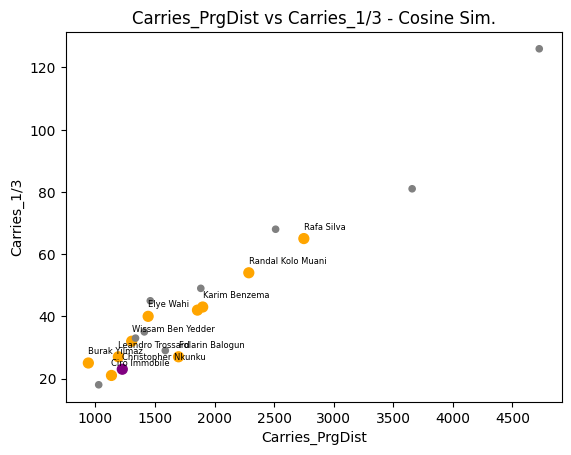

In [278]:
scatterplot_with_labels(weight_dimension_df, 'Carries_PrgDist', 'Carries_1/3', num_labels=10, top_size=50, rest_size=20, fontsize=6,dist_measure='Cosine Sim.')

#### Euclidean Distance

In [261]:
top_k_df[weight_dimension].head()

,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3
Player,,,,
Christopher Nkunku,2929.0,1225.0,43.0,23.0
Ciro Immobile,2914.0,1134.0,40.0,21.0
Burak Yılmaz,2377.0,940.0,36.0,25.0
Wissam Ben Yedder,3251.0,1304.0,48.0,32.0
Rafa Silva,5507.0,2749.0,99.0,65.0


In [280]:
from sklearn.metrics.pairwise import euclidean_distances

# get the feature columns that are weighted for criterion
start_index, end_index = get_feature_indices(weight_dimension)

# for nkunkung (795) and the feature columns
query_embedding = embeddings[795, start_index:end_index+1].reshape(1, -1)

# Compute Euclidean distances
distances = euclidean_distances(query_embedding, embeddings[:, start_index:end_index+1])

# Create a DataFrame of distances
distance_df = pd.DataFrame(distances.flatten(), index=df.index, columns=['Distance'])
similar_players = distance_df.sort_values(by='Distance')

similar_players.head(20)


,Distance
Player,
Christopher Nkunku,0.000000
Manu Vallejo,0.841861
Ollie Watkins,0.984864
Elye Wahi,1.351730
Ivan Toney,1.386342
Rasmus Højlund,1.601815
Enes Ünal,1.703959
Victor Osimhen,1.779331
Lautaro Martínez,1.915257


In [288]:
# Perform the join and sorting
result_df = df[weight_dimension].join(similar_players).sort_values('Distance')

# Remove duplicate index entries
result_df = result_df[~result_df.index.duplicated(keep='first')]
result_df = result_df.head(20)
# Display the first 20 rows
result_df.head(5)

,Carries_TotDist,Carries_PrgDist,Carries_PrgC,Carries_1/3,Distance
Player,,,,,
Christopher Nkunku,2929.0,1225.0,43.0,23.0,0.000000
Manu Vallejo,341.0,209.0,7.0,4.0,0.841861
Ollie Watkins,2519.0,1164.0,50.0,24.0,0.984864
Elye Wahi,3721.0,1442.0,57.0,40.0,1.351730
Ivan Toney,2463.0,724.0,14.0,21.0,1.386342


##### Visualize

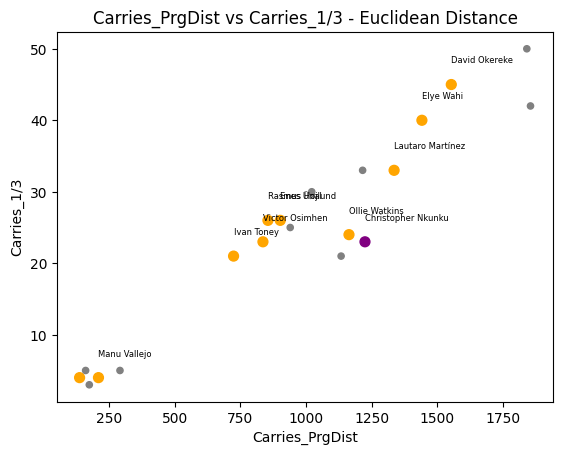

In [290]:
scatterplot_with_labels(result_df, 'Carries_PrgDist', 'Carries_1/3', num_labels=10, top_size=50, rest_size=20, fontsize=6,dist_measure='Euclidean Distance')

#### KNN

In [ ]:
# for nkunkung (795) and the feature columns
query_embedding = embeddings[795, start_index:end_index+1].reshape(1, -1)

# Compute Euclidean distances
distances = euclidean_distances(query_embedding, embeddings[:, start_index:end_index+1])

In [309]:
from sklearn.neighbors import NearestNeighbors

# weighted feature by criterion
start_index, end_index = get_feature_indices(weight_dimension)

# model 
knn = NearestNeighbors(n_neighbors=30, metric='cityblock')  # n_neighbors=2 because the closest will include itself
knn = knn.fit(embeddings[:, start_index:end_index+1])

# only the weighted feature criterion
query_embedding = embeddings[795, start_index:end_index+1].reshape(1, -1)

distances, indices = knn.kneighbors(query_embedding)

# Output the most similar player (excluding Christopher Nkunku itself)
nearest_neighbor_index = indices[0] # [1] because [0] will be Nkunku himself

result_df = player_info.iloc[nearest_neighbor_index]
result_df['Distance'] = distances[0]
result_df.drop(columns='unique_id')

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_17780\3350577596.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Distance'] = distances[0]


,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,Distance
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,0.000000
Manu Vallejo,2022-2023,LaLiga,Girona,Manu Vallejo,ESP,"FW,MF",FW,25.0,7.0,2.0,206.0,2.3,1.066289
Ollie Watkins,2022-2023,EPL,Aston Villa,Ollie Watkins,ENG,FW,FW,26.0,37.0,36.0,3127.0,34.7,1.684993
Ivan Toney,2022-2023,EPL,Brentford,Ivan Toney,ENG,FW,FW,26.0,33.0,33.0,2951.0,32.8,2.243458
Victor Osimhen,2022-2023,SeriaA,Napoli,Victor Osimhen,NGA,FW,FW,23.0,32.0,30.0,2566.0,28.5,2.475218
Elye Wahi,2022-2023,Ligue1,Montpellier,Elye Wahi,FRA,FW,FW,19.0,33.0,29.0,2513.0,27.9,2.637089
Rasmus Højlund,2022-2023,SeriaA,Atalanta,Rasmus Højlund,DEN,FW,FW,19.0,32.0,20.0,1834.0,20.4,2.700116
Enes Ünal,2022-2023,LaLiga,Getafe,Enes Ünal,TUR,FW,FW,25.0,35.0,35.0,2970.0,33.0,2.797591
Lautaro Martínez,2022-2023,SeriaA,Inter,Lautaro Martínez,ARG,FW,FW,24.0,38.0,27.0,2576.0,28.6,3.288162


##### Visualize

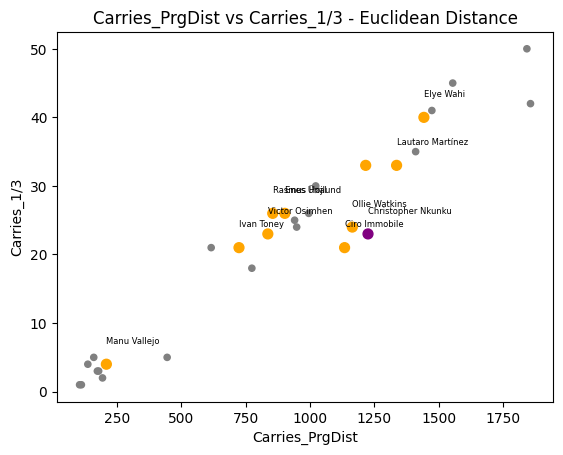

In [310]:
result_df = df[weight_dimension].iloc[nearest_neighbor_index]
scatterplot_with_labels(result_df, 'Carries_PrgDist', 'Carries_1/3', num_labels=10, top_size=50, rest_size=20, fontsize=6,dist_measure='Manhattan Distance')